**Tip:** Enable the GPU if you're running this notebook in [Colab](https://colab.research.google.com) 

* *Edit -> Notebook settings -> Hardware accellerator -> GPU*.

## Data augmentation

This notebook quickly demonstrates data augmentation. Much of the code is similar to the previous one (skim through those sections).

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

# The code in this notebook should work identically between TF v1 and v2
import tensorflow as tf
import zipfile

from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Download the dataset

In [2]:
!wget https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O /tmp/cats_and_dogs_filtered.zip

--2019-02-10 03:54:50--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.124.128, 2607:f8b0:4001:c0f::80
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.124.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘/tmp/cats_and_dogs_filtered.zip’

/tmp/cats_and_dogs_ 100%[===================>]  65.43M   183MB/s    in 0.4s    

2019-02-10 03:54:50 (183 MB/s) - ‘/tmp/cats_and_dogs_filtered.zip’ saved [68606236/68606236]



In [0]:
local_zip = '/tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp')
zip_ref.close()

In [0]:
base_dir = '/tmp/cats_and_dogs_filtered'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

## Explore the data

In [0]:
num_cats_tr = len(os.listdir(train_cats_dir))
num_dogs_tr = len(os.listdir(train_dogs_dir))

num_cats_val = len(os.listdir(validation_cats_dir))
num_dogs_val = len(os.listdir(validation_dogs_dir))

total_train = num_cats_tr + num_dogs_tr
total_val = num_cats_val + num_dogs_val

In [6]:
print('Training cat images:', num_cats_tr)
print('Training dog images:', num_dogs_tr)

print('Validation cat images:', num_cats_val)
print('Validation dog images:', num_dogs_val)

print("--")

print("Total training images:", total_train)
print("Total validation images:", total_val)

Training cat images: 1000
Training dog images: 1000
Validation cat images: 500
Validation dog images: 500
--
Total training images: 2000
Total validation images: 1000


### Reading images off disk

In [0]:
TARGET_SHAPE = 150 
BATCH_SIZE = 32

### Horizontal flip

In [0]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

In [9]:
train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                               class_mode='binary')

Found 2000 images belonging to 2 classes.


Let's apply this augmentation to a single image from our training set, five times.

In [0]:
augmented_images = [train_data_gen[0][0][0] for i in range(5)]

In [0]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.grid(False)
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

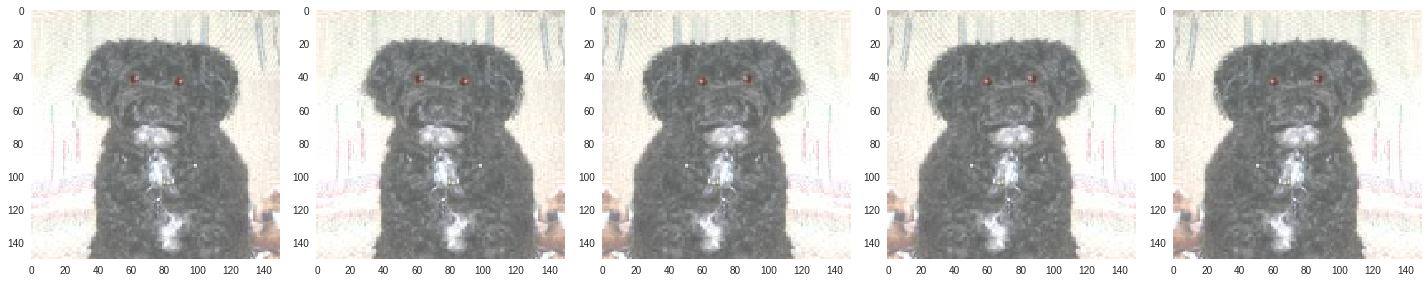

In [12]:
plotImages(augmented_images)

### Random rotation

Next, let's apply 45 degrees of rotation, randomly.

In [13]:
image_gen = ImageDataGenerator(rescale=1./255, rotation_range=45)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                               class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


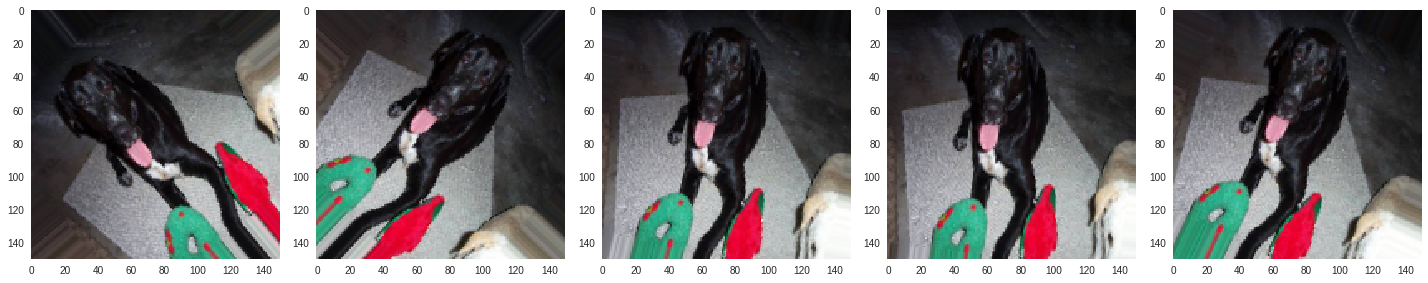

In [14]:
plotImages(augmented_images)

### Zoom

In [15]:
image_gen = ImageDataGenerator(rescale=1./255, zoom_range=0.5)

train_data_gen = image_gen.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                               class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


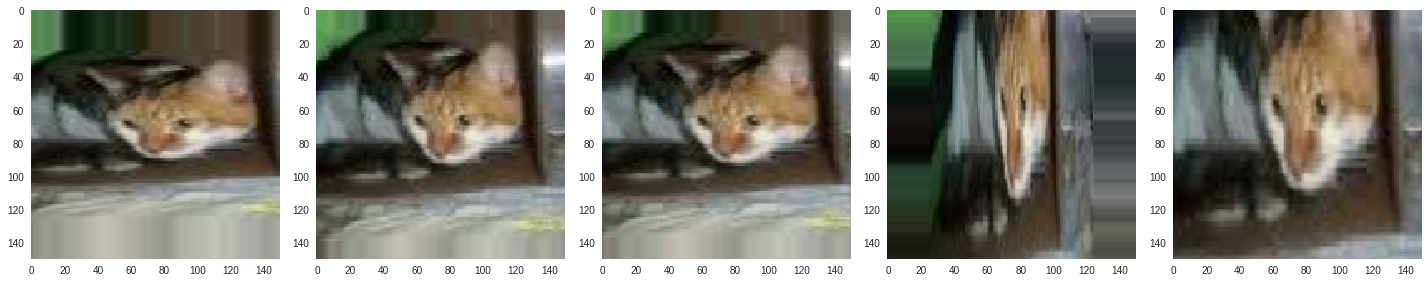

In [16]:
plotImages(augmented_images)

## Putting it together


In [17]:
image_gen_train = ImageDataGenerator(
                    rescale=1./255, 
                    rotation_range=45, 
                    width_shift_range=.15, 
                    height_shift_range=.15, 
                    horizontal_flip=True, 
                    zoom_range=0.5)


train_data_gen = image_gen_train.flow_from_directory(batch_size=BATCH_SIZE, 
                                               directory=train_dir, 
                                               shuffle=True, 
                                               target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                               class_mode='binary')

augmented_images = [train_data_gen[0][0][0] for i in range(5)]

Found 2000 images belonging to 2 classes.


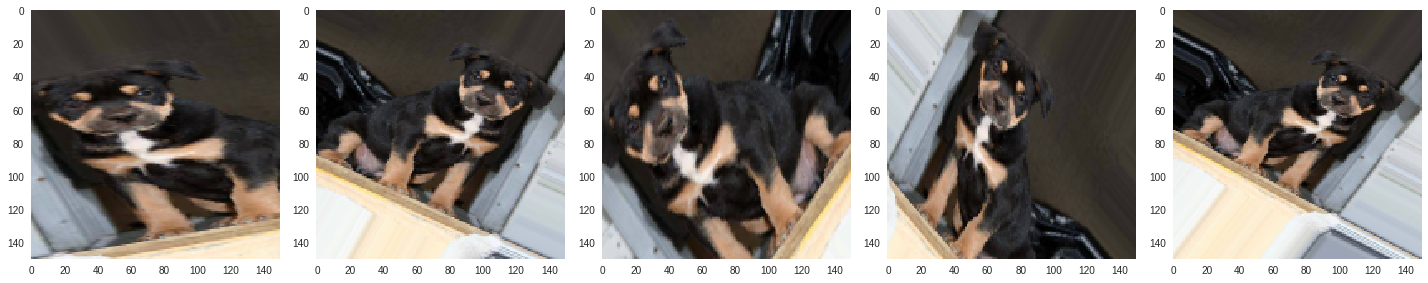

In [18]:
plotImages(augmented_images)

### Create the validation data generator

We only apply data augmentation to our training examples. Here, we just rescale our validation images, and converting them into batches, using ImageDataGenerator as before.

## Create and compile the network
We'll also use Dropout layers to reduce overfitting.

In [19]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(batch_size=BATCH_SIZE, 
                                                 directory=validation_dir, 
                                                 target_size=(TARGET_SHAPE, TARGET_SHAPE),
                                                 class_mode='binary')

Found 1000 images belonging to 2 classes.


In [20]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

model.compile(optimizer='adam', 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxP

## Train the model using data augmentation
This will be slower than before (data augmentation increases the size of our training set). We will also train for a bit longer.

In [0]:
EPOCHS = 50

In [22]:
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
    epochs=EPOCHS,
    validation_data=val_data_gen,
    validation_steps=int(np.ceil(total_val / float(BATCH_SIZE)))
)

Instructions for updating:
Use tf.cast instead.
Epoch 1/50
63/63 [==============================] - 34s 534ms/step - loss: 0.6996 - acc: 0.4960 - val_loss: 0.6916 - val_acc: 0.5000
Epoch 2/50
63/63 [==============================] - 37s 588ms/step - loss: 0.6940 - acc: 0.5000 - val_loss: 0.6931 - val_acc: 0.5000
Epoch 3/50
63/63 [==============================] - 38s 596ms/step - loss: 0.6917 - acc: 0.5190 - val_loss: 0.6891 - val_acc: 0.5010
Epoch 4/50
63/63 [==============================] - 37s 587ms/step - loss: 0.6866 - acc: 0.5445 - val_loss: 0.6796 - val_acc: 0.5610
Epoch 5/50
63/63 [==============================] - 37s 590ms/step - loss: 0.6910 - acc: 0.5230 - val_loss: 0.6840 - val_acc: 0.5160
Epoch 6/50
63/63 [==============================] - 36s 575ms/step - loss: 0.6906 - acc: 0.5310 - val_loss: 0.6810 - val_acc: 0.5850
Epoch 7/50
63/63 [==============================] - 21s 326ms/step - loss: 0.6822 - acc: 0.5670 - val_loss: 0.6795 - val_acc: 0.6330
Epoch 8/50
63/63 [===

### Results
Let's see how we did.

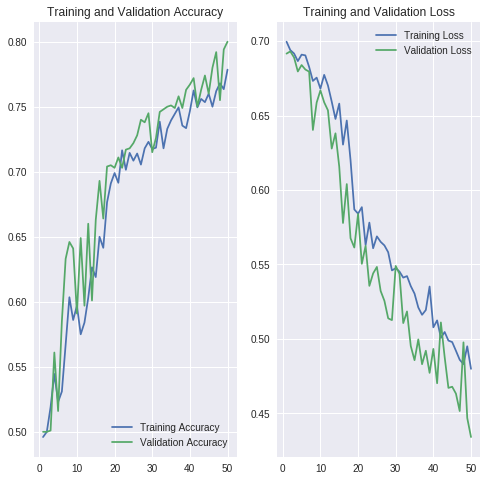

In [23]:
acc = history.history['acc']
val_acc = history.history['val_acc']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Better! Overfitting has been reduced compared to the previous notebook (we may benefit by training a bit longer, as well). Transfer learning is up next.